In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/zcapjru/PhD/DEScls/xcell/mappers')


from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_KV450
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 256
ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [3]:
path = '/home/zcapjru/PhD/Data/KV450/'

cats = [path+'KV450_G12_reweight_3x4x4_v2_good.cat', 
        path+'KV450_G23_reweight_3x4x4_v2_good.cat',
        path+'KV450_GS_reweight_3x4x4_v2_good.cat',
        path+'KV450_G15_reweight_3x4x4_v2_good.cat',
        path+'KV450_G9_reweight_3x4x4_v2_good.cat'
       ]
cats

['/home/zcapjru/PhD/Data/KV450/KV450_G12_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G23_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_GS_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G15_reweight_3x4x4_v2_good.cat',
 '/home/zcapjru/PhD/Data/KV450/KV450_G9_reweight_3x4x4_v2_good.cat']

In [4]:
KV_1_config = {'data_catalogs': cats , 
                'file_nz':path + 'REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_z0.1t0.3.asc',
          'bin':1,
          'nside':nside, 
          'mask_name': 'mask_KV450_1', 
          'lite_path': '/home/zcapjru/PhD/Data/KV_lite_cats/'}

KV_5_config = {'data_catalogs': cats ,               
                'file_nz':path + 'REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_z0.9t1.2.asc',
          'bin':5,
           'mask_name': 'mask_KV450_5',
          'nside':nside,
          'lite_path': '/home/zcapjru/PhD/Data/KV_lite_cats/'}

In [5]:
KV_1_maps = mapper_KV450.MapperKV450(KV_1_config)
KV_5_maps = mapper_KV450.MapperKV450(KV_5_config)

loading lite cat 0 loading lite cat 1 loading lite cat 2 loading lite cat 3 loading lite cat 4 Catalogs loaded loading lite cat 0 loading lite cat 1 loading lite cat 2 loading lite cat 3 loading lite cat 4 Catalogs loaded 

In [6]:
KV_nz_1 = KV_1_maps.dndz
KV_z_1 = KV_nz_1[0]
KV_dNdz_1 = KV_nz_1[1]

KV_nz_5 = KV_5_maps.dndz
KV_z_5 = KV_nz_5[0]
KV_dNdz_5 = KV_nz_5[1]

In [7]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
ia = np.ones(120)*0.981

KV_theory_1 = ccl.WeakLensingTracer(cosmo,  dndz=(KV_z_1,KV_dNdz_1), has_shear=True, ia_bias=(KV_z_1,ia), use_A_ia=True)
Theory_cl_s1s1 = ccl.angular_cl(cosmo, KV_theory_1, KV_theory_1, ell_arr) 

KV_theory_5 = ccl.WeakLensingTracer(cosmo,  dndz=(KV_z_5,KV_dNdz_5), has_shear=True, ia_bias=(KV_z_5,ia), use_A_ia=True)
Theory_cl_s5s5 = ccl.angular_cl(cosmo, KV_theory_5, KV_theory_5, ell_arr) 

Theory_cl_s1s5 = ccl.angular_cl(cosmo, KV_theory_1, KV_theory_5, ell_arr)

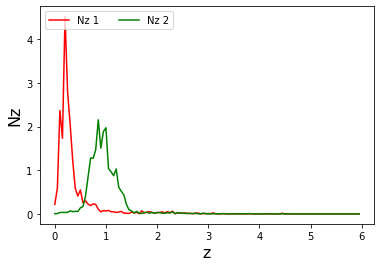

In [8]:
plt.plot(KV_z_1, KV_dNdz_1, 'r-', label='Nz 1')
plt.plot(KV_z_5, KV_dNdz_5, 'g-', label='Nz 2')

plt.xlabel('z', fontsize=16)
plt.ylabel('Nz', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

In [9]:
len(KV_1_maps.cat_data)

1027504

In [10]:
KV_shear_1 = KV_1_maps.get_signal_map(mode = 'shear')
KV_psf_1 = KV_1_maps.get_signal_map(mode = 'PSF')
KV_stars_1 = KV_1_maps.get_signal_map(mode = 'stars')

KV_shear_5 = KV_5_maps.get_signal_map(mode = 'shear')
KV_psf_5 = KV_5_maps.get_signal_map(mode = 'PSF')
KV_stars_5 = KV_5_maps.get_signal_map(mode = 'stars')

In [11]:
KV_galaxy_mask_1 = KV_1_maps.get_mask(mode='PSF')
KV_star_mask_1 = KV_1_maps.get_mask(mode='stars')
KV_galaxy_mask_1 = KV_1_maps.get_mask(mode='shear')

KV_galaxy_mask_5 = KV_5_maps.get_mask(mode='PSF')
KV_star_mask_5 = KV_5_maps.get_mask(mode='stars')
KV_galaxy_mask_5 = KV_5_maps.get_mask(mode='shear')

In [12]:
KV_shear_f_1 =   KV_1_maps.get_nmt_field()

KV_shear_f_5 =   KV_5_maps.get_nmt_field()

In [13]:
KV_w_s1s1 = nmt.NmtWorkspace()
KV_w_s1s1.compute_coupling_matrix(KV_shear_f_1, KV_shear_f_1, bands)

KV_w_s1s5 = nmt.NmtWorkspace()
KV_w_s1s5.compute_coupling_matrix(KV_shear_f_1, KV_shear_f_5, bands)

KV_w_s5s5 = nmt.NmtWorkspace()
KV_w_s5s5.compute_coupling_matrix(KV_shear_f_5, KV_shear_f_5, bands)

In [14]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [15]:
KV_nl_s1s1 = KV_1_maps.get_nl_coupled(mode='shear')
KV_nl_s1s1 = KV_w_s1s1.decouple_cell(KV_nl_s1s1)

KV_nl_s5s5 = KV_5_maps.get_nl_coupled(mode='shear')
KV_nl_s5s5 = KV_w_s5s5.decouple_cell(KV_nl_s5s5)

In [16]:
cl_s1s1 = compute_cl(KV_shear_f_1, KV_shear_f_1, KV_w_s1s1)
cl_s1s5 = compute_cl(KV_shear_f_1, KV_shear_f_5, KV_w_s1s5)
cl_s5s5 = compute_cl(KV_shear_f_5, KV_shear_f_5, KV_w_s5s5)
#print(cl_s1s1, KV_nl_s1s1)
#cl_s1s1 = cl_s1s1 - KV_nl_s1s1

In [17]:
def load_carlos_cl(a, b):
    return np.load('/home/zcapjru/PhD/Data/Carlos_KV/cl_KVwl{}_KVwl{}.npz'.format(a,b))
def load_jaime_cl(a, b):
    return np.loadtxt('/home/zcapjru/PhD/Cls/KV450/KV450_cl_{}{}.txt'.format(a,b))
def load_jaime_nl(a, b):
    return np.loadtxt('/home/zcapjru/PhD/Cls/KV450/KV450_nl_{}{}.txt'.format(a,b))

In [18]:
for i in range(5):
    for j in range(5):
        if i <= j:
            carlos_ij = load_carlos_cl(i,j)['cl'][0]
            jaime_ij = load_jaime_cl(i,j)[0]
            if i == j:
                jaime_ij = jaime_ij - load_jaime_nl(i,j)[0]
            diff = abs(carlos_ij - jaime_ij)
            print('for bin_{}{} the max error is {}'.format(i , j, max(diff)))

for bin_00 the max error is 1.1458483866624476e-16
for bin_01 the max error is 8.037996163484712e-17
for bin_02 the max error is 1.2863483720578663e-16
for bin_03 the max error is 3.096702559627173e-16
for bin_04 the max error is 1.278891993962746e-15
for bin_11 the max error is 2.487579602658036e-16
for bin_12 the max error is 4.6791097689543866e-17
for bin_13 the max error is 2.588316958105388e-16
for bin_14 the max error is 4.552451896307734e-16
for bin_22 the max error is 2.2536004097989005e-16
for bin_23 the max error is 1.4779168258392777e-16
for bin_24 the max error is 5.345489868071472e-16
for bin_33 the max error is 1.0072535801974733e-15
for bin_34 the max error is 1.4265687141579605e-15
for bin_44 the max error is 1.1839691276146845e-15


In [19]:
carlos11 = load_carlos_cl(0,0)
jcl11 = load_jaime_cl(0,0)[0]
jnl11 = load_jaime_nl(0,0)[0]

carlos15 = load_carlos_cl(0,4)
jcl15 = load_jaime_cl(0,4)[0]
#jnl11 = load_jaime_nl(0,4)[0]

carlos55 = load_carlos_cl(4,4)
jcl55 = load_jaime_cl(4,4)[0]
jnl55 = load_jaime_nl(4,4)[0]

In [20]:
print(len(jcl11), len(carlos11['nl'][0]))

39 39


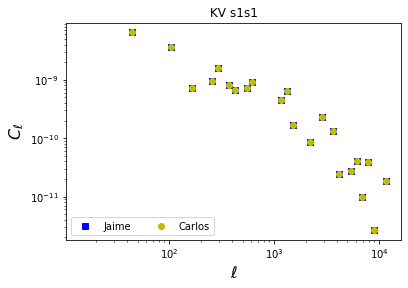

In [21]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos11['ell'], jcl11-jnl11, 'bs', label='Jaime')
plt.plot(carlos11['ell'], carlos11['cl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s1s1')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

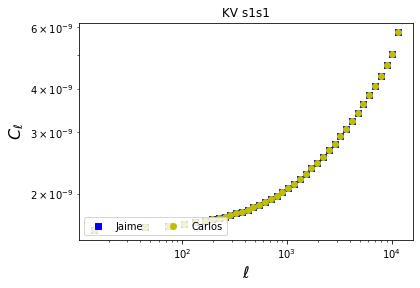

In [22]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos11['ell'], jnl11, 'bs', label='Jaime')
plt.plot(carlos11['ell'], carlos11['nl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s1s1')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

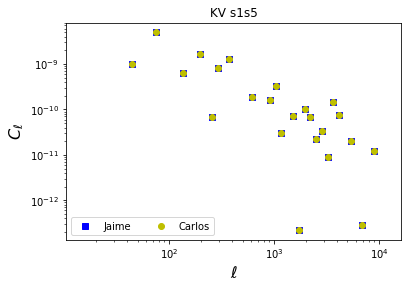

In [23]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos15['ell'], jcl15, 'bs', label='Jaime')
plt.plot(carlos15['ell'], carlos15['cl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s1s5')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

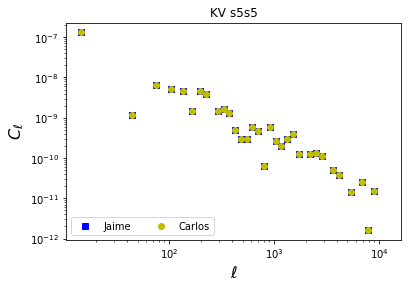

In [24]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos55['ell'], jcl55-jnl55, 'bs', label='Jaime')
plt.plot(carlos55['ell'], carlos55['cl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s5s5')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

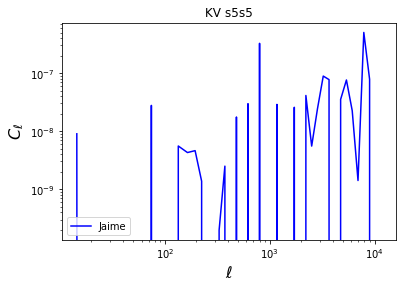

In [25]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos55['ell'], (jcl55-jnl55-carlos55['cl'][0])/carlos55['cl'][0], 'b-', label='Jaime')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s5s5')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

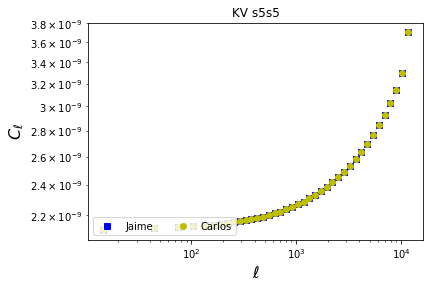

In [26]:
#plt.plot(ell_arr, cl_s1s1[0] -KV_nl_s1s1[0], 'bo-', label='Empirical')
plt.plot(carlos55['ell'], jnl55, 'bs', label='Jaime')
plt.plot(carlos55['ell'], carlos55['nl'][0] , 'yo', label='Carlos')
#plt.plot(ell_arr,Theory_cl_s1s1, 'r--', label='Theory')

#plt.plot(ell_arr, DES_theory_11, 'r--', label='Theory cl_ij')
#plt.plot(ccl_11['ell'], ccl_11['cl'][0], 'g-', label='Carlos cl_ij')

plt.loglog()
plt.title('KV s5s5')
#plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()